In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit # shorthand for the sigmoid function
from sklearn.neural_network import MLPClassifier # a nonparametric classifier (other options could be SVM, Random Forest, etc.)
from sklearn.base import clone # for cloning sklearn models
from joblib import Parallel, delayed # for parallel processing
from pandas import json_normalize # shortand to flatten nested JSON objects
import seaborn as sns
import time
import datetime

In [2]:
def prob_death_under_no_ttt(X): return expit(np.sin(X))
def prob_death_under_ttt(X): return expit(0.5*np.sin(X)-.1)

In [3]:
def plot_prob_death(prec=1000):
    x = np.linspace(-1, 1, prec)
    y0 = prob_death_under_no_ttt(x)
    y1 = prob_death_under_ttt(x)
    plt.figure(figsize=(8, 8)) 
    plt.plot(x, y0, color='black', linewidth=3, linestyle='--', label='Probability of death when treatment is NOT given')
    plt.plot(x, y1, color='black', linewidth=3, label='Probability of death when treatment is given')
    plt.fill_between(x, y0, y1, where=(y1 >= y0), facecolor='red', alpha=1, interpolate=True, label='Treatment is harmful for these patients') 
    plt.fill_between(x, y0, y1, where=(y0 > y1), facecolor='green', alpha=1, interpolate=True, label='Treatment is beneficial for these patients') 
    plt.xlabel('X i.e., a patient characteristic')
    plt.ylabel('P(death|X, TTT) and P(death|X, no TTT)\ni.e., prognostic functions')
    plt.title('Simulated prognostic functions\nwhen treatment is given vs. not given')
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

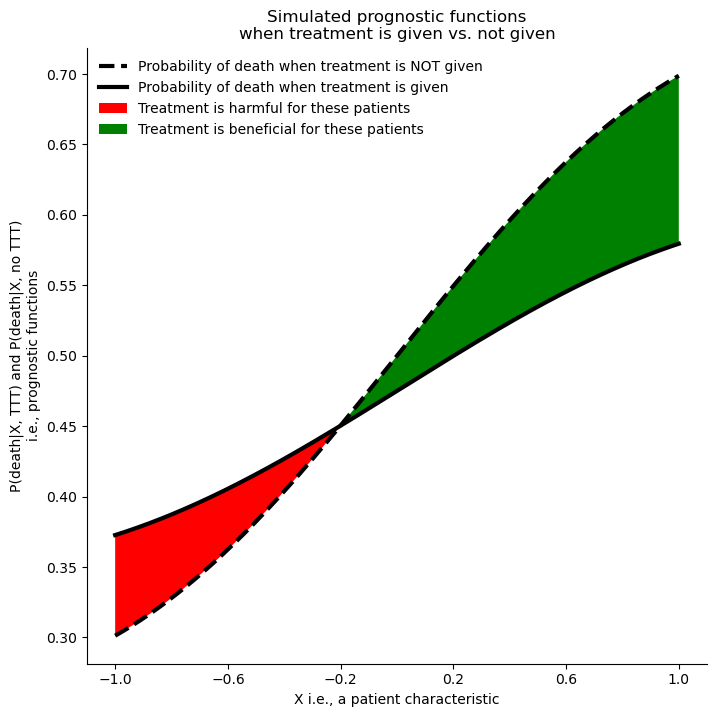

In [4]:
plot_prob_death()

In [105]:
def plot_individualized_ttt_effects(prec=100000):
    x = np.linspace(-1, 1, prec)
    y = prob_death_under_ttt(x) - prob_death_under_no_ttt(x)
    true_ate = np.mean(y)
    plt.figure(figsize=(7, 7)) 
    plt.axhline(0, color='black', linewidth=1, linestyle='--', label='Line of no treatment effect')
    plt.plot(x[y>=0], y[y>=0], color='red', linewidth=5, label='Treatment is harmful for these patients') 
    plt.plot(x[y<0], y[y<0], color='green', linewidth=5, label='Treatment is beneficial for these patients')
    plt.axhline(true_ate, color='black', linewidth=5, label=f'Average treatment effect ({true_ate*100:.2f}%)')
    plt.xlabel('X i.e., a patient characteristic')
    plt.ylabel('P(death|X, TTT) - P(death|X, no TTT)\ni.e., conditional treatment effect')
    plt.title('Simulated conditional treatment effects')
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    return true_ate

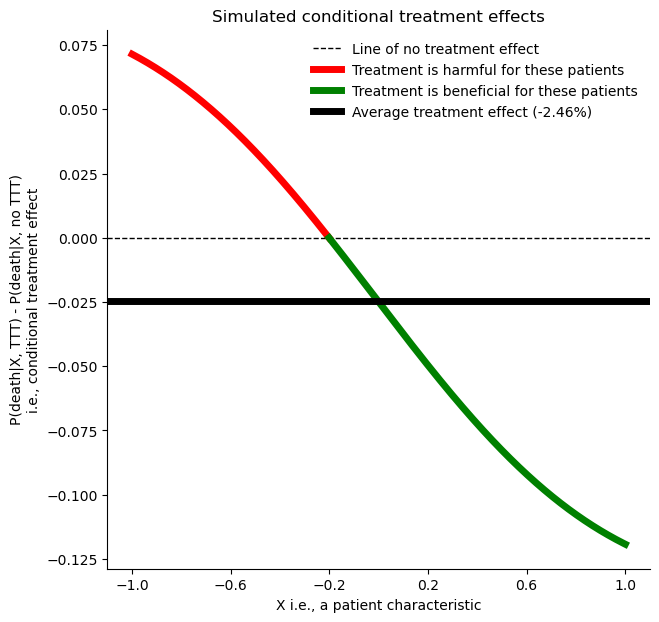

In [106]:
true_ate = plot_individualized_ttt_effects();

In [7]:
def generate_data(n_samples):
    # sample X from a uniform distribution
    X = np.random.uniform(-1,1, n_samples)

    # sample from a bernoulli distribution
    T = np.random.binomial(1, np.cos(X), n_samples)
    Y_t0 = np.random.binomial(1, prob_death_under_no_ttt(X), n_samples)
    Y_t1 = np.random.binomial(1, prob_death_under_ttt(X), n_samples)

    # apply the consistency assumption
    Y = T * Y_t1 + (1-T) * Y_t0
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y, 'Y_t0': Y_t0, 'Y_t1': Y_t1})
    

In [8]:
# test the function
super_population = generate_data(10000)

# print the first few rows of the dataframe rounded to 2 decimal places
super_population.round(2).head()

,X,T,Y,Y_t0,Y_t1
0,-0.19,1,1,0,1
1,-0.35,1,0,0,0
2,0.64,1,0,1,0
3,0.36,1,0,1,0
4,-0.59,1,0,1,0


In [9]:
def g_comp_ate_estimator(data, sk_model):
    # Prepare prognostic models for T == 1 and T == 0
    pr_model_t1 = clone(sk_model)
    pr_model_t0 = clone(sk_model)
    
    # Get inputs and targets for T == 1 (i.e., subgroup where treatment is given)
    inputs_t1 = data["X"][data["T"]==1].values.reshape(-1, 1)
    targets_t1 = data["Y"][data["T"]==1]
    
    # Fit the model for the subgroup where treatment is given
    pr_model_t1.fit(inputs_t1, targets_t1)

    # For all patients, predict probabilities of death if the treatment were given
    predicted_proba_t1 = pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Get inputs and targets for T == 0 (i.e., subgroup where treatment is not given)
    inputs_t0 = data["X"][data["T"]==0].values.reshape(-1, 1)
    targets_t0 = data["Y"][data["T"]==0].values
    
    # Fit the model for the subgroup where treatment is NOT given
    pr_model_t0.fit(inputs_t0, targets_t0)
    
    # For all patients, predict probabilities of death if the treatment were NOT given
    predicted_proba_t0 = pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Compute the g-computation estimate of the ATE
    gcomp_ate_estimate = np.mean(predicted_proba_t1 - predicted_proba_t0)
    return gcomp_ate_estimate, pr_model_t1, pr_model_t0

In [10]:
# take a sample of size 10000 from the super_population
data = super_population.iloc[:1000, :3]

# Instantiate a nonparametric classifier (multi-layer perceptron with 2 hidden units here but could be any other model)
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation="logistic", solver="lbfgs", max_iter=5000, random_state=42)

# test the estimator function
g_comp_ate_estimator(data, mlp_model)

(np.float64(0.001281001992523346),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'))

In [11]:
def ipw_ate_estimator(data, sk_model):
    # Prepare the propensity score model P(T=1|X)
    ps_model = clone(sk_model)
    
    # Get inputs and targets for the propensity score model
    inputs = data["X"].values.reshape(-1, 1)
    targets = data["T"]
    
    # Fit the propensity score model P(T=1|X)
    ps_model.fit(inputs, targets)

    # For all patients, predict probabilities of receiving treatment
    predicted_proba = ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Calculate the weights of the treated as the inverse probabilty of being treated
    w_t1 = data["T"] / predicted_proba
    
    # Calculate the weights of the untreated as the inverse probabilty of being NOT being treated 
    w_t0 = (1 - data["T"]) / (1 - predicted_proba)
    
    # Compute the IPW estimate of the ATE
    ipw_ate_estimate = np.mean((w_t1 - w_t0) * data["Y"])
    
    # Normalize the weights
    w_t1_normalized = w_t1 / np.sum(w_t1)
    w_t0_normalized = w_t0 / np.sum(w_t0)
    
    # Compute the IPW estimate of the ATE using normalized weights
    ipw_ate_estimate_normalized = np.sum((w_t1_normalized - w_t0_normalized) * data["Y"])
    
    return ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model

In [12]:
#test the estimator function
ipw_ate_estimator(data, mlp_model)

(np.float64(0.010936418509250178),
 np.float64(0.004925949766790547),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'))

In [13]:
# We can obtain estimates and fitted models from our functions as follows
gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, mlp_model)
ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, mlp_model)

In [14]:
def aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model):
    top_left = 2 * data["T"] - 1
    pr_model_preds = data["T"] * pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    top_right = data["Y"] - pr_model_preds
    denominator = data["T"] * ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * (1 - ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1])
    correction_term = top_left * top_right / denominator
    aipw_ate_estimate = gcomp_ate_estimate + np.mean(correction_term)
    return aipw_ate_estimate

In [15]:
def apply_estimators(data, sk_model):
    """
    Input:
    - data: a pandas dataframe containing the data with columns X, T, and Y
    - sk_model: an instance of a scikit-learn classifier
    Output:
    - gcomp_ate_estimate: the g-computation estimate of the ATE
    - ipw_ate_estimate: the IPW estimate of the ATE
    - ipw_ate_estimate_normalized: the IPW estimate of the ATE using normalized weights
    - aipw_ate_estimate: the AIPW estimate of the ATE
    """
    gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, sk_model)
    ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, sk_model)
    aipw_ate_estimate = aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model)
    return gcomp_ate_estimate, ipw_ate_estimate, ipw_ate_estimate_normalized, aipw_ate_estimate

In [16]:
class Simulation:
    def __init__(self, s_size, n_sim, generate_data, true_ate, sk_model):
        self.s_size = s_size
        self.n_sim = n_sim
        self.generate_data = generate_data
        self.true_ate = true_ate
        self.sk_model = sk_model
    
    def sim_superpop_and_idxs(self):
        # Create a superpopulation that of size s_size*n_sim
        self.superpop = self.generate_data(self.s_size * self.n_sim)[["X", "T", "Y"]]

        # Create a list of lists of indices for the simulations
        self.sim_idx_s = [range(it * self.s_size, it * self.s_size + self.s_size) for it in range(self.n_sim)]
        self.sim_idx_s = list(map(list, self.sim_idx_s))
        # sim_idx_s is of the form [[0, 1,.., s_size-1], [s_size, s_size+1,.., 2*s_size-1], ...]

        # Confirm that the superpopulation is large enough for the simulation size
        assert self.sim_idx_s[-1][-1] < self.superpop.shape[0], "The dataset is too small for the simulation size (sample size * number of simulations)"
        
    def run_one_simulation(self, sim_idx):
        # Prepare the data for the simulation iteration
        data = self.superpop.iloc[sim_idx]
        gcomp, ipw, ipw_normalized, aipw = apply_estimators(data, self.sk_model)
        
        # Save the results by appending a new row to the results dataframe
        iteration_result = {"iteration": sim_idx[0]//len(sim_idx),
                            "gcomp": gcomp,
                            "ipw": ipw,
                            "ipw_normalized": ipw_normalized,
                            "aipw": aipw}
        return iteration_result

    def run_all_simulations(self):
        # Run all simulations in parallel
        self.results = Parallel(n_jobs=-1)(delayed(self.run_one_simulation)(sim_idx) for sim_idx in self.sim_idx_s)
        # Save the results in a dataframe
        self.results = pd.DataFrame(self.results)
    
    def process_results(self):
        # Calulate bias, variance, MSE and coverage
        estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
        mse = (self.results[estimators] - self.true_ate).pow(2).mean(axis=0)
        bias = self.results[estimators].mean(axis=0) - self.true_ate
        variance = self.results[estimators].var(axis=0) # this is normalized by N-1 by default
        self.analyzed_results = {"n_sim": self.n_sim, "s_size": self.s_size, "mse": dict(mse), "bias": dict(bias), "variance": dict(variance)}

In [17]:
sim_instance = Simulation(s_size=200, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
sim_instance.sim_superpop_and_idxs()
sim_instance.run_one_simulation(sim_instance.sim_idx_s[0])

{'iteration': 0,
 'gcomp': np.float64(0.27751880464096396),
 'ipw': np.float64(0.313485976001532),
 'ipw_normalized': np.float64(0.12353568524906908),
 'aipw': np.float64(0.28366279821429286)}

In [18]:
sim_instance.run_one_simulation(sim_instance.sim_idx_s[1])

{'iteration': 1,
 'gcomp': np.float64(-0.06522098356884859),
 'ipw': np.float64(0.13301596754291117),
 'ipw_normalized': np.float64(-0.0542930608650076),
 'aipw': np.float64(-0.06112092241192011)}

In [19]:
sim_instance.run_all_simulations()

/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/py

In [20]:
sim_instance.results

,iteration,gcomp,ipw,ipw_normalized,aipw
0,0,0.277519,0.313486,0.123536,0.283663
1,1,-0.065221,0.133016,-0.054293,-0.061121
2,2,-0.042157,0.194790,-0.046746,-0.033363
3,3,-0.139821,0.122995,-0.133708,-0.090668
4,4,-0.200808,0.170866,0.009247,-0.057783
...,...,...,...,...,...
994,994,0.270852,0.229099,-0.064646,0.276435
995,995,-0.005714,0.213984,-0.013430,-0.009412
996,996,0.003287,-0.082789,-0.080534,0.004048
997,997,-0.127816,-0.032331,-0.209046,-0.127350


In [21]:
sim_instance.process_results()
sim_instance.analyzed_results

{'n_sim': 999,
 's_size': 200,
 'mse': {'gcomp': np.float64(0.02406768483511532),
  'ipw': np.float64(0.046224949054561267),
  'ipw_normalized': np.float64(0.014894194650962105),
  'aipw': np.float64(0.024368815615159956)},
 'bias': {'gcomp': np.float64(0.004343667245839761),
  'ipw': np.float64(0.1808013956340727),
  'ipw_normalized': np.float64(-0.008809176184304865),
  'aipw': np.float64(0.004694374121690419)},
 'variance': {'gcomp': np.float64(0.024072914401385516),
  'ipw': np.float64(0.013549367321584621),
  'ipw_normalized': np.float64(0.01483143935155315),
  'aipw': np.float64(0.024371174036371523)}}

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42, verbose=False)


In [23]:
s_sizes = np.logspace(np.log10(500.5), np.log10(10000), num=5, dtype=int)
s_sizes


array([  500,  1058,  2237,  4729, 10000])

In [24]:
all_results = []

sim_start_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Starting simulation at {sim_start_time}\n")
for s_size in s_sizes:
    start_time = time.time()
    print(f"Running simulations for sample size n={s_size}...\n")
    
    sim = Simulation(s_size=s_size, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
    sim.sim_superpop_and_idxs()
    sim.run_all_simulations()
    sim.process_results()
    all_results.append(sim)
    
    end_time = time.time()
    hours, rem = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"... took {int(hours)}h {int(minutes)}m {seconds:.1f}s\n")
        
sim_end_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Simulation finished at {sim_end_time}")

Starting simulation at 2024-12-03-09-54-40

Running simulations for sample size n=500...

... took 0h 0m 18.7s

Running simulations for sample size n=1058...

... took 0h 0m 27.4s

Running simulations for sample size n=2237...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 0m 45.2s

Running simulations for sample size n=4729...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 1m 15.7s

Running simulations for sample size n=10000...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 2m 16.4s

Simulation finished at 2024-12-03-09-59-43


In [143]:
float_res_df = json_normalize([sim.analyzed_results for sim in all_results])
float_res_df.columns = [col.replace('.', '_') for col in results_df.columns]
float_res_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.003894,0.014756,0.005404,0.005194,0.005370,0.102326,0.003097,0.004672,0.003869,0.004290,0.005400,0.005177
1,999,1058,0.001689,0.009352,0.002839,0.002577,0.001237,0.082689,-0.001383,-0.000598,0.001689,0.002517,0.002840,0.002579
2,999,2237,0.000862,0.006686,0.001477,0.001356,0.002231,0.072001,-0.000180,0.000632,0.000858,0.001503,0.001479,0.001357
3,999,4729,0.000428,0.004822,0.000727,0.000689,0.002317,0.063905,0.000121,0.000858,0.000423,0.000739,0.000728,0.000689
4,999,10000,0.000221,0.004308,0.000334,0.000308,0.002534,0.058927,0.000971,0.001400,0.000215,0.000836,0.000334,0.000306


In [ ]:
# Prepare the table for better visualization
# (this part is a bit convoluted and not particulary insighful)
def highlight_cells(x):
    # Create an empty DataFrame with the same shape as x
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    # Apply the mask only to numeric columns
    df.iloc[:, 2:] = 'background-color: gray'
    for col in x.columns:
        if "bias" in col:
            df.loc[:, col] = 'background-color: darkgray'
        for metric in ["mse", "bias", "variance"]:
            if metric in col:
                # gymastic below to remove minus signs as appropriate and compare color the winner estimators in green
                mask = x[col].apply(lambda x: x[1:-1] if x[0] == "-" else x[:-1]) == results_df[[f"{metric}_gcomp", f"{metric}_ipw", f"{metric}_ipw_normalized", f"{metric}_aipw"]].apply(lambda xx: min([x[1:-1] if x[0] == "-" else x[:-1] for x in xx]), axis=1)
                df.loc[mask, col] = 'background-color: green'    
    return df

# Define a custom function to format the values
def format_percentage(x):
    if isinstance(x, float):
        return f"{x * 100:.2f}%"
    return x

# Apply the custom function to all but the first two columns
results_df = float_res_df.astype(object)
results_df.iloc[:, 2:] = results_df.iloc[:, 2:].map(format_percentage)

# Apply the custom function to the DataFrame
styled_results_df = results_df.style.apply(highlight_cells, axis=None).set_table_styles(
    {
        f'{metric}_gcomp': [{'selector': 'td', 'props': [('border-left', '4px solid black')]}] for metric in ["mse", "bias", "variance"]
    }
)

# Display the DataFrame with superheaders
styled_results_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.39%,1.48%,0.54%,0.52%,0.54%,10.23%,0.31%,0.47%,0.39%,0.43%,0.54%,0.52%
1,999,1058,0.17%,0.94%,0.28%,0.26%,0.12%,8.27%,-0.14%,-0.06%,0.17%,0.25%,0.28%,0.26%
2,999,2237,0.09%,0.67%,0.15%,0.14%,0.22%,7.20%,-0.02%,0.06%,0.09%,0.15%,0.15%,0.14%
3,999,4729,0.04%,0.48%,0.07%,0.07%,0.23%,6.39%,0.01%,0.09%,0.04%,0.07%,0.07%,0.07%
4,999,10000,0.02%,0.43%,0.03%,0.03%,0.25%,5.89%,0.10%,0.14%,0.02%,0.08%,0.03%,0.03%


In [ ]:
# Prepare the data for visualization
# (this part is a bit convoluted and not particulary insighful)
estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
estimates = pd.concat([pd.concat([all_results[i].results[estimator] for estimator in estimators]) for i in range(len(all_results))])
repeated_estimators = [item for item in estimators for _ in range(all_results[0].n_sim)]
repeated_estimators = repeated_estimators * len(all_results)
repeated_s_sizes = [[s_size] * all_results[0].n_sim * len(estimators) for s_size in s_sizes]
repeated_s_sizes = [item for sublist in repeated_s_sizes for item in sublist]
len(repeated_s_sizes), len(repeated_estimators), len(estimates)
# put the results in a dataframe
violin_df = pd.DataFrame({"Estimators": repeated_estimators, "Sample Size": repeated_s_sizes, "Estimations": estimates})
violin_df['Estimators'] = violin_df['Estimators'].replace({
    'gcomp': 'G-computation',
    'ipw': 'IPW',
    'ipw_normalized': 'normalized IPW',
    'aipw': 'AIPW'
})

In [113]:
def plot_violin(violin_df, true_ate):
    plt.figure(figsize=(12, 8))
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    unique_sample_sizes = violin_df['Sample Size'].unique()
    custom_palette = {size: color for size, color in zip(unique_sample_sizes, sns.color_palette("colorblind", len(unique_sample_sizes)))}

    sns.violinplot(x='Estimators', y='Estimations', hue='Sample Size', data=violin_df, split=False, palette=custom_palette)
    plt.axhline(y=true_ate, color='red', linewidth=3, label='True ATE')
    plt.legend(title='Sample Size', frameon=False)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(f'Average Treatment Effect Estimators\nComputed for {all_results[0].n_sim} Simulation Iterations', fontsize=16)
    plt.xlabel('Estimators', fontsize=14)
    plt.ylabel('Estimations', fontsize=14)

    plt.show()

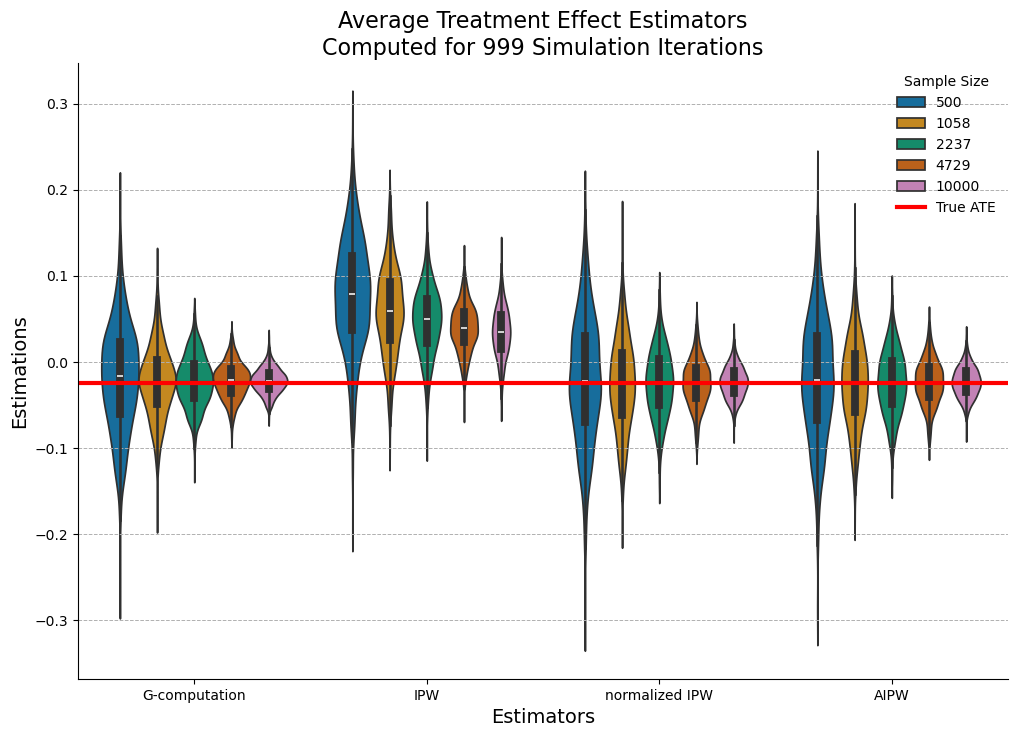

In [117]:
plot_violin(violin_df, true_ate);

In [185]:
loglog_df = pd.concat([np.log(float_res_df["s_size"]), np.log(float_res_df[[col for col in float_res_df.columns if "variance" in col]])], axis=1)
loglog_df.columns = ["log_s_size", "log_variance_gcomp", "log_variance_ipw", "log_variance_ipw_normalized", "log_variance_aipw"]
loglog_df

,log_s_size,log_variance_gcomp,log_variance_ipw,log_variance_ipw_normalized,log_variance_aipw
0,6.214608,-5.554681,-5.451472,-5.221335,-5.263514
1,6.964136,-6.383666,-5.984648,-5.864046,-5.960363
2,7.712891,-7.061194,-6.500158,-6.516707,-6.602280
3,8.461469,-7.768074,-7.210670,-7.224919,-7.279613
4,9.210340,-8.444227,-7.086411,-8.005249,-8.091101


In [191]:
def variance_plot(loglog_df):
    # Define the x-axis and y-axis columns
    x_col = 'log_s_size'
    loglog_df.columns = ["log_s_size", "G-computation", "IPW", "normalized IPW", "AIPW"]
    y_cols = ["G-computation", "IPW", "normalized IPW", "AIPW"]

    # Set the color palette to "colorblind"
    colors = sns.color_palette("colorblind", len(y_cols))

    # Create a scatter plot
    plt.figure(figsize=(8, 8))

    for i, y_col in enumerate(y_cols):
        # Scatter plot
        plt.scatter(loglog_df[x_col], loglog_df[y_col], label=y_col, color=colors[i], marker='o', s=100)
        
        # Calculate the regression line
        slope, intercept = np.polyfit(loglog_df[x_col], loglog_df[y_col], 1)
        regression_line = slope * loglog_df[x_col] + intercept
        
        # Plot the regression line
        plt.plot(loglog_df[x_col], regression_line, color=colors[i], linestyle='--', linewidth=2, label=None)

    # Add labels and legend
    plt.xlabel('Log Sample Size', fontsize=14)
    plt.ylabel('Log Estimator Variance', fontsize=14)
    plt.legend(frameon=False)
    plt.title('Asymptotic Behavior of Estimators:\nVariances and Convergence Rates', fontsize=16)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

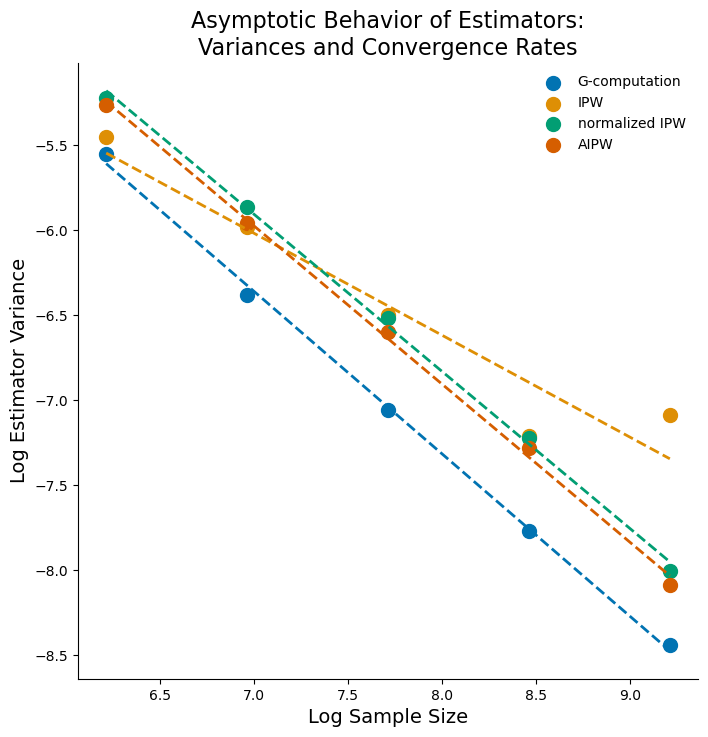

In [193]:
variance_plot(loglog_df)